# 4. Evaluating and Improving Models

Training a deep learning model is an art, and to make sure our model is trained correctly, we need to keep track of certain metrics during training, such as the loss or the accuracy. We will learn how to calculate such metrics and how to reduce overfitting using an image dataset as an example.

### Preparing the environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics

from environment import prepare_environment

from mpl_toolkits.axes_grid1 import ImageGrid
from pprint import pprint

from torch.utils.data import TensorDataset, DataLoader
from torch.nn import CrossEntropyLoss
from torchvision.transforms import v2

In [2]:
SEED = 42
prepare_environment()

torch.set_printoptions(precision=10)

### Check if your GPU driver and CUDA is enabled and accessible by PyTorch

In [3]:
torch.cuda.is_available()

True

## 4.1 A deeper dive into loading data

### Animals dataset

In [4]:
df_animal = pd.read_csv('data-sources/animals.csv')
print(df_animal.shape)
df_animal.head()
# Type key: mammal (1), bird (2), reptile (3), fish (4), amphibian (5), bug (6), invertebrate (7)

(101, 18)


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### Defining features and target

In [5]:
# We are using only hair, feathers, eggs, milk, predator, fins, legs, and tail
X = df_animal[['hair', 'feathers', 'eggs', 'milk', 'predator', 'fins', 'legs', 'tail']].values
y = df_animal['class_type'].values
print(f'''
Features:
{X[:3]}

Target:
{y[:3]}
''')


Features:
[[1 0 0 1 1 0 4 0]
 [1 0 0 1 0 0 4 1]
 [0 0 1 0 1 1 0 1]]

Target:
[1 1 4]



### Recalling TensorDataset

In [6]:
# Instantiate dataset class
dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(y).float())

In [7]:
# Access an individual sample
sample = dataset[0]
input_sample, label_sample = sample
print('input sample:', input_sample)
print('label_sample:', label_sample)

input sample: tensor([1., 0., 0., 1., 1., 0., 4., 0.])
label_sample: tensor(1.)


### Recalling DataLoader

In [8]:
batch_size = 25
shuffle = True

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
# Iterate over the dataloader
for i, (batch_inputs, batch_labels) in enumerate(dataloader):
    print('Batch', i)
    print('Total rows:', batch_inputs.shape[0])
    print('batch inputs first row', batch_inputs[:1])
    print('batch labels first row', batch_labels[:1])

Batch 0
Total rows: 25
batch inputs first row tensor([[1., 0., 0., 1., 1., 0., 4., 0.]])
batch labels first row tensor([1.])
Batch 1
Total rows: 25
batch inputs first row tensor([[1., 0., 0., 1., 1., 0., 4., 0.]])
batch labels first row tensor([1.])
Batch 2
Total rows: 25
batch inputs first row tensor([[1., 0., 0., 1., 0., 0., 4., 1.]])
batch labels first row tensor([1.])
Batch 3
Total rows: 25
batch inputs first row tensor([[0., 0., 1., 0., 0., 0., 0., 0.]])
batch labels first row tensor([7.])
Batch 4
Total rows: 1
batch inputs first row tensor([[0., 0., 1., 0., 1., 1., 0., 1.]])
batch labels first row tensor([4.])


### Ex.1 - Using the TensorDataset class
In practice, loading your data into a PyTorch dataset will be one of the first steps you take in order to create and train a neural network with PyTorch.

The `TensorDataset` class is very helpful when your dataset can be loaded directly as a NumPy array. Recall that `TensorDataset()` can take one or more NumPy arrays as input.

In this exercise, you'll practice creating a PyTorch dataset using the `TensorDataset` class.

`torch` and `numpy` have already been imported for you, along with the `TensorDataset` class.

**Instructions**

1. Convert the NumPy arrays provided to PyTorch tensors.
2. Create a TensorDataset using the torch_features and the torch_target tensors provided (in this order).
3. Return the last element of the dataset.

In [10]:
np_features = np.array(np.random.rand(12, 8))
np_target = np.array(np.random.rand(12, 1))

# Convert arrays to PyTorch tensors
torch_features = torch.tensor(np_features)
torch_target = torch.tensor(np_target)

# Create a TensorDataset from two tensors
dataset = TensorDataset(torch_features, torch_target)

# Return the last element of this dataset
print(dataset[-1])

(tensor([0.8872127426, 0.4722149252, 0.1195942459, 0.7132447872, 0.7607850486,
        0.5612771976, 0.7709671800, 0.4937955964], dtype=torch.float64), tensor([0.7555511385], dtype=torch.float64))


### Ex.2 - From data loading to running a forward pass

In this exercise, you'll create a PyTorch DataLoader from a pandas DataFrame and call a model on this dataset. Specifically, you'll run a forward pass on a neural network. You'll continue working with fully connected neural networks, as you have done so far.

You'll begin by subsetting a loaded DataFrame called dataframe, converting features and targets NumPy arrays, and converting to PyTorch tensors in order to create a PyTorch dataset.

This dataset can be loaded into a PyTorch DataLoader, batched, shuffled, and used to run a forward pass on a custom fully connected neural network.

NumPy as np, pandas as pd, torch, TensorDataset(), and DataLoader() have been imported for you.

**Instructions**

1. Extract the features (`ph`, `Sulfate`, `Conductivity`, `Organic_carbon`) and target (`Potability`) values and load them into the appropriate tensors to represent features and targets.
2. Use both tensors to create a PyTorch dataset using the dataset class that's quickest to use when tensors don't require any additional preprocessing.
3. Create a PyTorch DataLoader from the created `TensorDataset`; this `DataLoader` should use a `batch_size` of two and `shuffle` the dataset.
4. Implement a small, fully connected neural network using exactly two linear layers and the `nn.Sequential()` API, where the final output size is 1.

In [11]:
df_water = pd.read_csv('data-sources/water_potability.csv')
print(df_water.shape)
print(df_water.Potability.value_counts())
df_water.head()

(2011, 10)
Potability
0    1200
1     811
Name: count, dtype: int64


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.587349,0.577747,0.386298,0.568199,0.647347,0.292985,0.654522,0.795029,0.630115,0
1,0.643654,0.441300,0.314381,0.439304,0.514545,0.356685,0.377248,0.202914,0.520358,0
2,0.388934,0.470876,0.506122,0.524364,0.561537,0.142913,0.249922,0.401487,0.219973,0
3,0.725820,0.715942,0.506141,0.521683,0.751819,0.148683,0.467200,0.658678,0.242428,0
4,0.610517,0.532588,0.237701,0.270288,0.495155,0.494792,0.409721,0.469762,0.585049,0


In [12]:
# Load the different columns into two PyTorch tensors
features = torch.tensor(df_water[['ph', 'Sulfate',
                                   'Conductivity', 'Organic_carbon']].to_numpy()).float()
target = torch.tensor(df_water['Potability'].to_numpy()).float()

# Create a dataset from the two generated tensors
dataset = TensorDataset(features, target)

# Create a dataloader using the above dataset
dataloader = DataLoader(dataset, shuffle=True, batch_size=2)
x, y = next(iter(dataloader))

# Create a model using the nn.Sequential API
model = nn.Sequential(
    nn.Linear(4, 2),
    nn.Linear(2, 1)
)
output = model(features)
print(output)

tensor([[-0.5961157084],
        [-0.5502838492],
        [-0.5151942372],
        ...,
        [-0.5749674439],
        [-0.5613026619],
        [-0.5903500319]], grad_fn=<AddmmBackward0>)


## 4.2 Evaluating model performance

### Animal Dataset

#### Splitting into Training, validation and testing

In [13]:
# Working again with the animal dataset
# We are using only hair, feathers, eggs, milk, predator, fins, legs, and tail
Xa = df_animal[['hair', 'feathers', 'eggs', 'milk', 'predator', 'fins', 'legs', 'tail']].values
ya = df_animal['class_type'].values - 1

# Encoding the target variable
# Type key: mammal (1), bird (2), reptile (3), fish (4), amphibian (5), bug (6), invertebrate (7)
ya = F.one_hot(torch.tensor(ya), num_classes=7)

# Instantiate dataset class
dataset_a = TensorDataset(torch.tensor(Xa).float(), ya.float())

# Last item in dataset
dataset_a[-1]

(tensor([0., 1., 1., 0., 0., 0., 2., 1.]),
 tensor([0., 1., 0., 0., 0., 0., 0.]))

In [14]:
# Reproducibility
torch.manual_seed(SEED)

# Splitting into training, validation and testing set
train_set_a, val_set_a = torch.utils.data.random_split(dataset_a, [.8, .2])
val_set_a, test_set_a = torch.utils.data.random_split(val_set_a, [.5, .5])

len(train_set_a), len(val_set_a), len(test_set_a)

(81, 10, 10)

In [15]:
# Reproducibility
torch.manual_seed(SEED)

# Recalling the DataLoader
batch_size_a = 100
shuffle_a = True
trainloader_a = DataLoader(train_set_a, batch_size=batch_size_a, shuffle=shuffle_a)
valloader_a = DataLoader(val_set_a, batch_size=batch_size_a, shuffle=shuffle_a)
testloader_a = DataLoader(test_set_a, batch_size=batch_size_a, shuffle=shuffle_a)

#### Training the model

In [16]:
# Reproducibility
torch.manual_seed(SEED)

# Setting the model
model_a = nn.Sequential(
    nn.Linear(8, 16),
    nn.Linear(16, 7),
    nn.Softmax(dim=-1)  # Softmax activation
)

# Create the loss and Optimizer
criterion_a = CrossEntropyLoss()
optimizer_a = optim.SGD(model_a.parameters(), lr=0.001, momentum=0.95)

In [17]:
# Loop through the dataset multiple times
num_epochs_a = 100
epochs_training_loss_a = []
model_a.train()
for epoch in range(num_epochs_a):
    training_loss_a = 0.0
    for i, data in enumerate(trainloader_a):
        # Get feature and target from the data loader
        X_a, y_a = data

        # zero the parameter gradients
        optimizer_a.zero_grad()

        # Run a forward pass
        pred_a = model_a(X_a)
    
        # Compute loss 
        loss = criterion_a(pred_a, y_a)
        training_loss_a += loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer_a.step()
    
    # Calculate the mean loss value
    training_loss_a = training_loss_a / len(trainloader_a)
    epochs_training_loss_a.append(training_loss_a.item())
    print(f'Epoch {epoch}: Loss >> {training_loss_a}')

Epoch 0: Loss >> 1.9347037076950073
Epoch 1: Loss >> 1.9346528053283691
Epoch 2: Loss >> 1.9345533847808838
Epoch 3: Loss >> 1.9344080686569214
Epoch 4: Loss >> 1.9342190027236938
Epoch 5: Loss >> 1.9339874982833862
Epoch 6: Loss >> 1.933715581893921
Epoch 7: Loss >> 1.9334050416946411
Epoch 8: Loss >> 1.9330570697784424
Epoch 9: Loss >> 1.932673454284668
Epoch 10: Loss >> 1.9322551488876343
Epoch 11: Loss >> 1.9318033456802368
Epoch 12: Loss >> 1.9313191175460815
Epoch 13: Loss >> 1.9308034181594849
Epoch 14: Loss >> 1.9302573204040527
Epoch 15: Loss >> 1.929681658744812
Epoch 16: Loss >> 1.9290765523910522
Epoch 17: Loss >> 1.928443431854248
Epoch 18: Loss >> 1.9277830123901367
Epoch 19: Loss >> 1.9270950555801392
Epoch 20: Loss >> 1.9263806343078613
Epoch 21: Loss >> 1.9256399869918823
Epoch 22: Loss >> 1.9248740673065186
Epoch 23: Loss >> 1.9240822792053223
Epoch 24: Loss >> 1.9232655763626099
Epoch 25: Loss >> 1.92242431640625
Epoch 26: Loss >> 1.9215587377548218
Epoch 27: Loss >>

In [18]:
# Calculate the mean loss value
np.mean(epochs_training_loss_a)

1.8841560423374175

### FaceMask Dataset

#### Reading data

In [19]:
Xface, yface = pd.read_pickle('data-sources/masks_dataset.pickle')
print(f"""
Features: {Xface.shape} = {np.prod(Xface.shape[1:])}
Target: {set(yface)} = {len(set(yface))}
""")


# Reshaping the images set to have the channel in the second dimension
Xface = np.transpose(Xface, (0, 3, 1, 2))
print(f"Features after transposing demensions: {Xface.shape} = {np.prod(Xface.shape[1:])}")

type(Xface), type(yface)


Features: (355, 32, 32, 3) = 3072
Target: {0, 1, 2} = 3

Features after transposing demensions: (355, 3, 32, 32) = 3072


(numpy.ndarray, numpy.ndarray)

#### Splitting into Training, validation and testing

In [20]:
# Encoding the target variable
yface_encoded = F.one_hot(torch.tensor(yface), num_classes=len(set(yface)))

# Instantiate dataset class
dataset_face = TensorDataset(torch.tensor(Xface).float(), yface_encoded.float())

# # Last item in dataset
# dataset_face[-1]

In [21]:
# Reproducibility
torch.manual_seed(SEED)

# Splitting into training, validation and testing set
train_set_face, val_set_face = torch.utils.data.random_split(dataset_face, [.8, .2])
val_set_face, test_set_face = torch.utils.data.random_split(val_set_face, [.5, .5])

len(train_set_face), len(val_set_face), len(test_set_face)

(284, 36, 35)

In [22]:
# Reproducibility
torch.manual_seed(SEED)

# Recalling the DataLoader
batch_size_face = 100
shuffle_face = True
trainloader_face = DataLoader(train_set_face, batch_size=batch_size_face, shuffle=shuffle_face)
valloader_face = DataLoader(val_set_face, batch_size=batch_size_face, shuffle=shuffle_face)
testloader_face = DataLoader(test_set_face, batch_size=batch_size_face, shuffle=shuffle_face)

# print target in the last element of the train loader
print('Last target in train loader:', trainloader_face.dataset[-1][1])  # 0 is the features
len(trainloader_face.dataset), len(valloader_face.dataset), len(testloader_face.dataset)

Last target in train loader: tensor([0., 1., 0.])


(284, 36, 35)

#### Training the model

In [23]:
# Reproducibility
torch.manual_seed(SEED)

# Getting mean and std per channel in images:
mean = np.mean(Xface, axis=(0, 2, 3))
std = np.std(Xface, axis=(0, 2, 3))

# Setting the model
model_face = nn.Sequential(
    v2.Normalize(mean=mean, std=std),
    nn.Flatten(),
    nn.Linear(3072, 3),
    nn.Softmax(dim=-1)  # Softmax activation
)

# Create the loss and Optimizer
criterion_face = CrossEntropyLoss()
optimizer_face = optim.SGD(model_face.parameters(), lr=0.001, momentum=0.95)

model_face

Sequential(
  (0): Normalize(mean=[0.5137812899236973, 0.4499961909157517, 0.422587966943309], std=[0.250811625348822, 0.24213039004760292, 0.24616128365795462], inplace=False)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=3072, out_features=3, bias=True)
  (3): Softmax(dim=-1)
)

In [24]:
# Loop through the dataset multiple times
num_epochs_face = 100
epochs_training_loss_face = []
model_face.train()
for epoch in range(num_epochs_face):
    training_loss_face = 0.0
    for i, data in enumerate(trainloader_face):
        # Get feature and target from the data loader
        X_face, y_face = data

        # zero the parameter gradients
        optimizer_face.zero_grad()

        # Run a forward pass
        pred_face = model_face(X_face)
    
        # Compute loss 
        loss = criterion_face(pred_face, y_face)
        training_loss_face += loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer_face.step()
    
    # Calculate the mean loss value
    training_loss_face = training_loss_face / len(trainloader_face)
    epochs_training_loss_face.append(training_loss_face.item())
    print(f'Epoch {epoch}: Loss >> {training_loss_face}')

Epoch 0: Loss >> 1.1058155298233032
Epoch 1: Loss >> 1.0287917852401733
Epoch 2: Loss >> 0.9581666588783264
Epoch 3: Loss >> 0.9120866656303406
Epoch 4: Loss >> 0.896742045879364
Epoch 5: Loss >> 0.8842758536338806
Epoch 6: Loss >> 0.8771467208862305
Epoch 7: Loss >> 0.8692712187767029
Epoch 8: Loss >> 0.859844982624054
Epoch 9: Loss >> 0.8523675799369812
Epoch 10: Loss >> 0.8431875705718994
Epoch 11: Loss >> 0.8300666809082031
Epoch 12: Loss >> 0.8224826455116272
Epoch 13: Loss >> 0.8171380162239075
Epoch 14: Loss >> 0.8074149489402771
Epoch 15: Loss >> 0.7983210682868958
Epoch 16: Loss >> 0.7968728542327881
Epoch 17: Loss >> 0.7847030162811279
Epoch 18: Loss >> 0.7791962027549744
Epoch 19: Loss >> 0.7755926251411438
Epoch 20: Loss >> 0.7695341110229492
Epoch 21: Loss >> 0.7636486887931824
Epoch 22: Loss >> 0.7597458958625793
Epoch 23: Loss >> 0.7525960803031921
Epoch 24: Loss >> 0.7483388781547546
Epoch 25: Loss >> 0.7440455555915833
Epoch 26: Loss >> 0.7398379445075989
Epoch 27: Los

In [25]:
# Calculate the mean loss value
np.mean(epochs_training_loss_face)

0.7067523473501205

### Calculating accuracy with torchmetrics

In [26]:
# Categories predicted
target = torch.tensor([0, 1, 2, 3])
preds = torch.tensor([0, 1, 1, 3])
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=4)
accuracy(preds, target)

tensor(0.7500000000)

In [27]:
# Probabilities predicted
target = torch.tensor([0, 1, 1])
preds = torch.tensor([[0.1, 0.9, 0], [0.3, 0.1, 0.6], [0.2, 0.5, 0.3]])  # [1, 2, 1]
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3)
accuracy(preds, target)

tensor(0.3333333433)

### Ex.3 - Writing the evaluation loop
In this exercise, you will practice writing the evaluation loop. Recall that the evaluation loop is similar to the training loop, except that you will not perform the gradient calculation and the optimizer step.

The model has already been defined for you, along with the object validationloader, which is a dataset.

**Instructions**
1. Set the model to evaluation mode.
2. Sum the current batch loss to the validation_loss variable.

#### FaceMask Dataset

In [28]:
# Set the model to evaluation mode
# using validation loader
model_face.eval()
validation_loss_face = 0.0

with torch.no_grad():
  for data in valloader_face:
      # Get feature and target from the data loader
      X_f, y_f = data
      print(len(X_f))
      # Get predictions
      pred_f = model_face(X_f)
      loss = criterion_face(pred_f,y_f)
      
      # Sum the current loss to the validation_loss variable
      validation_loss_face += loss.item()
      
# Calculate the mean loss value
validation_loss_face = validation_loss_face / len(valloader_face)
print(f'Validation Set: Loss >> {validation_loss_face}')

36
Validation Set: Loss >> 0.7663740515708923


In [29]:
# Set the model to evaluation mode
# using testing loader
model_face.eval()
test_loss_face = 0.0

with torch.no_grad():
  for data in testloader_face:
      # Get feature and target from the data loader
      X_f, y_f = data

      # Get predictions
      pred_f = model_face(X_f)
      loss = criterion_face(pred_f,y_f)
      
      # Sum the current loss to the test_loss variable
      test_loss_face += loss.item()
      
# Calculate the mean loss value
test_loss_face = test_loss_face / len(testloader_face)
print(f'Validation Set: Loss >> {test_loss_face}')

Validation Set: Loss >> 0.6815488338470459


#### Animal Dataset

In [30]:
# Reproduce the evaluation mode with the recently created animal model
# using validation loader
model_a.eval()
validation_loss_a = 0.0
with torch.no_grad():
    for data in valloader_a:
        # Get feature and target from the data loader
        X_a, y_a = data

        # Get predictions
        pred_a = model_a(X_a)
        
        # Compute loss
        loss = criterion_a(pred_a, y_a)
        validation_loss_a += loss.item()

# Calculate the mean loss value
validation_loss_a = validation_loss_a / len(valloader_a)
print(f'Validation Set: Loss >> {validation_loss_a}')

Validation Set: Loss >> 1.9442341327667236


In [31]:
# Reproduce the evaluation mode with the recently created animal model
# using test loader
model_a.eval()
test_loss_a = 0.0
with torch.no_grad():
    for data in testloader_a:
        # Get feature and target from the data loader
        X_a, y_a = data

        # Get predictions
        pred_a = model_a(X_a)
        
        # Compute loss
        loss = criterion_a(pred_a, y_a)
        test_loss_a += loss.item()

# Calculate the mean loss value
test_loss_a = test_loss_a / len(testloader_a)
print(f'Test Set: Loss >> {test_loss_a}')

Test Set: Loss >> 1.6684391498565674


### Ex.4 - Calculating accuracy using torchmetrics
In addition to the losses, you should also be keeping track of the accuracy during training. By doing so, you will be able to select the epoch when the model performed the best.

In this exercise, you will practice using the torchmetrics package to calculate the accuracy. You will be using a sample of the facemask dataset. This dataset contains three different classes. The plot_errors function will display samples where the model predictions do not match the ground truth. Performing such error analysis will help you understand your model failure modes.

The torchmetrics package is already imported. The model outputs are the probabilities returned by a softmax as the last step of the model. The labels tensor contains the labels as one-hot encoded vectors.

**Instructions**

1. Create an accuracy metric for a "multiclass" problem with three classes.
2. Calculate the accuracy for each batch of the dataloader.
3. Calculate accuracy for the epoch.
4. Reset the metric for the next epoch.

In [32]:
# Utilities
def plot_errors(model, dataloader):
    # find mismatches
    mismatches = []
    for data in dataloader:
        if len(mismatches) > 8:
            break
        features, labels = data
        outputs = model(features)
        gt = labels.argmax(-1)
        pred = outputs.argmax(-1)
        for f, g, p in zip(features, gt, pred):
            if g != p:
                mismatches.append((f, g, p))

    grid_size = (1, 1) if len(mismatches) == 1 else (2, int(len(mismatches)/2))
    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(grid_size[0], grid_size[1]),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    mapping = {0: 'No mask', 1: 'Mask', 2: 'Incorrect'}
    for idx, ax in enumerate(grid):
        ax.imshow(mismatches[idx][0].permute(1, 2, 0))
        ax.set_title(f'GT: {mapping[mismatches[idx][1].item()]}\n'
                     f'PRED: {mapping[mismatches[idx][2].item()]}',
                     fontsize=8)
        ax.axis('off')
    plt.show()

#### FaceMask Dataset

Accuracy on all data: 0.8857142925262451


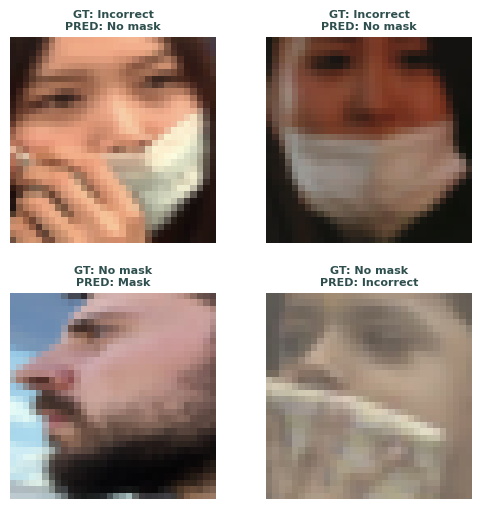

In [33]:
# Create accuracy metric using torch metrics
metric_face = torchmetrics.Accuracy(task="multiclass", num_classes=3)
model_face.eval()
for data in testloader_face:
    features_face, labels_face = data
    preds_face = model_face(features_face)
    
    # Calculate accuracy over the batch
    acc_face = metric_face(preds_face, labels_face.argmax(dim=-1))

# Calculate accuracy over the whole epoch
acc_face = metric_face.compute()
print(f"Accuracy on all data: {acc_face}")

# Reset the metric for the next epoch 
metric_face.reset()
plot_errors(model_face, testloader_face)

## 4.3 Fighting overfitting

### "Regularization" using a dropout layer

In [34]:
model = nn.Sequential(
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)
features = torch.randn((1, 8))
model(features)

tensor([[1.0026257038, 0.0000000000, 1.5434504747, 0.4614934921]],
       grad_fn=<MulBackward0>)

### Regularization with weight decay

In [35]:
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

### Data augmentation

In [36]:
# For one image
H, W = 32, 32
img = torch.randn(size=(3, H, W))
print(f"""Image Original: {img.shape}, {img[0,0,:5]}""")

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=1),
    # v2.RandomVerticalFlip(p=1),
    v2.RandomRotation(degrees=0.25)
])
img2 = transforms(img)
print(f"""Image Original: {img2.shape}, {img2[0,0,:5]}""")

Image Original: torch.Size([3, 32, 32]), tensor([-1.0754086971, -0.6555078626, -0.5378220081, -0.3389993906,
        -0.2735834718])
Image Original: torch.Size([3, 32, 32]), tensor([-0.9207187891, -0.6282665133,  0.0403232016, -1.9813779593,
        -0.9896361828])


In [37]:
# For multiple images
H, W = 32, 32
img = torch.randn(size=(100, 3, H, W))
print(f"""Image Original: {img.shape}, {img[0,0,0,:5]}""")

img2 = transforms(img)
print(f"""Image Original: {img2.shape}, {img2[0,0,0,:5]}""")

Image Original: torch.Size([100, 3, 32, 32]), tensor([-1.4802397490, -0.0286441874, -1.3437269926,  1.9430443048,
         0.3965672255])
Image Original: torch.Size([100, 3, 32, 32]), tensor([ 0.0726564080,  1.0365434885, -1.6077550650,  0.3780807555,
         0.9528230429])


### Ex.5 - Experimenting with dropout
The dropout layer randomly zeroes out elements of the input tensor. Doing so helps fight overfitting. In this exercise, you'll create a small neural network with one linear layer, one dropout layer, and one activation function.

The torch.nn package has already been imported as nn. An input_tensor of dimensions 
 has been created for you.

**Instructions**

1. Create a small neural network with one linear layer, one ReLU function, and one dropout layer, in that order.
The model should take input_tensor as input and return an output of size 16.
2. Using the same neural network, set the probability of zeroing out elements in the dropout layer to 0.8.

In [38]:
# Create a small neural network with one linear layer, one ReLU function, 
# and one dropout layer, in that order. The model should take input_tensor a
# s input and return an output of size 16.
input_tensor = torch.randn(size=(1, 3072))
model = nn.Sequential(
    nn.Linear(3072, 16),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)
model(input_tensor)

tensor([[0.0000000000, 1.2192028761, 0.0000000000, 0.0000000000, 0.0000000000,
         0.0000000000, 0.7582120299, 0.0000000000, 0.0000000000, 0.0000000000,
         0.0000000000, 0.5747761130, 0.4815210402, 0.0000000000, 1.4105589390,
         0.0592599101]], grad_fn=<MulBackward0>)

In [39]:
# Using the same neural network, set the probability of zeroing out elements 
# in the dropout layer to 0.8.
model = nn.Sequential(
    nn.Linear(3072, 16),
    nn.ReLU(),
    nn.Dropout(p=0.8)
)
model(input_tensor)

tensor([[0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
         0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000, 0.0000000000,
         0.0000000000, 1.2595785856, 0.0000000000, 0.0000000000, 0.0000000000,
         0.0000000000]], grad_fn=<MulBackward0>)

## 4.4 Improving model performance

### Steps to maximize performance
- Overfit the training set
    - can we solve the problem?
    - sets a performance baseline
- Reduce overfitting
    - improve performances on the validation set
- Fine-tune hyperparameters

In [40]:
# Util functions
def optimize_and_plot(
    model, X, y, optimizer, criterion,
    num_epochs=100
):
    losses = []
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the loss for plotting
        losses.append(loss.item())

        # Print the loss every 100 epochs and add a red marker
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.10f}')
            plt.scatter(epoch + 1, loss.item(), color='red', marker='o')

    # Plot the loss over epochs
    plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

### Working again with the FaceMask

In [41]:
# Getting X and y
X, y = pd.read_pickle('data-sources/masks_dataset.pickle')
print(f"Original shape in features: {X.shape} = {np.prod(X.shape[1:])}")

# Reshaping the images set to have the channel in the second dimension
X = torch.tensor(np.transpose(X, (0, 3, 1, 2)))

# Encoding the target variable
y = F.one_hot(torch.tensor(y), num_classes=len(set(y)))
print(f"""
Features: {type(X)} >> {X.shape} = {np.prod(X.shape[1:])}
Target  : {type(y)} >> {y.shape} = {np.prod(y.shape[1:])}
""")

Original shape in features: (355, 32, 32, 3) = 3072

Features: <class 'torch.Tensor'> >> torch.Size([355, 3, 32, 32]) = 3072
Target  : <class 'torch.Tensor'> >> torch.Size([355, 3]) = 3



In [42]:
# Instantiate dataset class and splitting into train, val and test set
dataset = TensorDataset(X.float(), y.float())

# Reproducibility
torch.manual_seed(SEED)

# Splitting into training, validation and testing set
train_set, val_set = torch.utils.data.random_split(dataset, [.8, .2])
val_set, test_set = torch.utils.data.random_split(val_set, [.5, .5])

len(train_set), len(val_set), len(test_set)

# Recalling the DataLoader
shuffle = True
train_loader = DataLoader(train_set, shuffle=shuffle)
val_loader = DataLoader(val_set, shuffle=shuffle)
test_loader = DataLoader(test_set, shuffle=shuffle)

# print shape of each loader
print(f"Train size: {len(train_loader)}, Val size: {len(val_loader)}, Test size: {len(test_loader)}")

Train size: 284, Val size: 36, Test size: 35


In [43]:
# Getting mean and std per channel in images:
mean = np.mean(X.numpy(), axis=(0, 2, 3))
std = np.std(X.numpy(), axis=(0, 2, 3))

# Setting the model
model = nn.Sequential(
    v2.Normalize(mean=mean, std=std),
    nn.Flatten(),
    nn.Linear(3072, 3),
    nn.Softmax(dim=-1)  # Softmax activation
)

# Create the loss and Optimizer
criterion = CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.85)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

model

Sequential(
  (0): Normalize(mean=[0.5137812899236973, 0.4499961909157517, 0.422587966943309], std=[0.250811625348822, 0.24213039004760292, 0.24616128365795462], inplace=False)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=3072, out_features=3, bias=True)
  (3): Softmax(dim=-1)
)

#### Step 1 - overfit the training set

In [44]:
# Setting the accuracy metric
metric_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3)

# model training
features, labels = next(iter(train_loader))
model.train()
for i in range(int(1e3)):
    optimizer.zero_grad()  # zero the parameter gradients
    outputs = model(features)  # Run a forward pass
    loss = criterion(outputs, labels)  # Compute loss 
    loss.backward()  # Backward pass and optimization
    optimizer.step()
    accuracy = metric_accuracy(outputs, labels.argmax(dim=-1))

    # Print the loss every 100 epochs and add a red marker
    if (i + 1) % 100 == 0:
        print(f'Epoch [{i+1}], Loss: {loss.item():.4f}, Accuracy: {accuracy}')

# Calculate accuracy over the whole epoch
accuracy_training = metric_accuracy.compute()
print(f"""
Accuracy on training set: {accuracy}
Last loss: {loss}
""")

Epoch [100], Loss: 0.5515, Accuracy: 1.0
Epoch [200], Loss: 0.5515, Accuracy: 1.0
Epoch [300], Loss: 0.5515, Accuracy: 1.0
Epoch [400], Loss: 0.5515, Accuracy: 1.0
Epoch [500], Loss: 0.5515, Accuracy: 1.0
Epoch [600], Loss: 0.5515, Accuracy: 1.0
Epoch [700], Loss: 0.5515, Accuracy: 1.0
Epoch [800], Loss: 0.5515, Accuracy: 1.0
Epoch [900], Loss: 0.5515, Accuracy: 1.0
Epoch [1000], Loss: 0.5515, Accuracy: 1.0

Accuracy on training set: 1.0
Last loss: 0.5514927506446838



Epoch [100/1000], Loss: 0.5514901876
Epoch [200/1000], Loss: 0.5514879823
Epoch [300/1000], Loss: 0.5514860153
Epoch [400/1000], Loss: 0.5514841676
Epoch [500/1000], Loss: 0.5514825583
Epoch [600/1000], Loss: 0.5514810681
Epoch [700/1000], Loss: 0.5514796376
Epoch [800/1000], Loss: 0.5514782667
Epoch [900/1000], Loss: 0.5514770150
Epoch [1000/1000], Loss: 0.5514760017


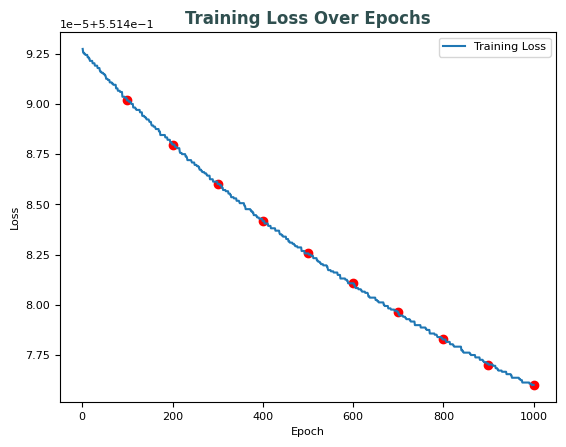

In [45]:
optimize_and_plot(
    model=model, X=features, y=labels,
    optimizer=optimizer, criterion=criterion, num_epochs=int(1e3)
)

#### Step 2 - Reduce overfitting

In [46]:
# Getting the accuracy in validation set
metric_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=3)
model.eval()
for data in val_loader:
    # Predict
    features, labels = data
    outputs = model(features)
    
    # Calculate accuracy over the batch
    accuracy = metric_accuracy(outputs, labels.argmax(dim=-1))

# Calculate accuracy over the whole set
accuracy_validation = metric_accuracy.compute()
print(f"Accuracy on Training set: {accuracy_training}")
print(f"Accuracy on Validation set: {accuracy_validation}")

Accuracy on Training set: 1.0
Accuracy on Validation set: 0.5277777910232544


#### Step 3 - fine-tune hyperparameters

In [47]:
# Grid search
lr = []
for factor in range(2, 6):
    lr.append(10 ** -factor)
print(lr)

[0.01, 0.001, 0.0001, 1e-05]


In [48]:
# Random search
factor = np.random.uniform(2, 6, size=2)
lr = 10 ** -factor
print(lr)

[0.00121565 0.00492131]


### Ex.6 - Implementing random search
Hyperparameter search is a computationally costly approach to experiment with different hyperparameter values. However, it can lead to performance improvements. In this exercise, you will implement a random search algorithm.

You will randomly sample 10 values of the learning rate and momentum from the uniform distribution. To do so, you will use the `np.random.uniform()` function.

The `numpy` package has already been imported as `np`.

**Instructions**

1. Randomly sample a learning rate factor between `2` and `4` so that the learning rate (`lr`) is bounded between $ 10^{-2} $ and $ 10^{-4} $
2. Randomly sample a momentum between 0.85 and 0.99.

In [49]:
# Reproducibility
np.random.seed(SEED)

# Randomly select lr and momentum
values = []
for idx in range(10):
    # Randomly sample a learning rate factor between 2 and 4
    factor = np.random.uniform(2, 4)
    lr = 10 ** -factor
    
    # Randomly select a momentum between 0.85 and 0.99
    momentum = np.random.uniform(0.85, 0.99)
    
    values.append((lr, momentum))
pprint(values)

[(0.0017820494960458736, 0.9831000028973882),
 (0.00034356753295316134, 0.9338121877875851),
 (0.00487486641279196, 0.8718392328470683),
 (0.00765301872013926, 0.9712646604084909),
 (0.0006277257966292396, 0.9491301608914464),
 (0.009095592845966645, 0.9857873793026792),
 (0.00021632898788517975, 0.8797274754949587),
 (0.004328626018623386, 0.8756766313794807),
 (0.002463289831513468, 0.9234659004285133),
 (0.0013680751763426263, 0.8907720796277259)]


-------------------------------------